In [132]:
import pandas as pd

# 确保所有列都能显示出来
pd.set_option('display.max_columns', 500)

# 确保列宽足够，不会把长字符串（比如 Method 名）截断
pd.set_option('display.max_colwidth', 100)

# 确保表格的总宽度足够，不会换行显示
pd.set_option('display.width', 1000)

In [133]:
TASK_METRIC = {
    "cola": ["eval_matthews_correlation"],
    "mnli": ["matched_accuracy", "mismatched_accuracy"],
    "mrpc": ["eval_accuracy", "eval_f1"],
    "qnli": ["eval_accuracy"],
    "qqp": ["eval_accuracy", "eval_f1"],
    "rte": ["eval_accuracy"],
    "sst2": ["eval_accuracy"],
    "stsb": ["eval_pearson", "eval_spearman"],
    "wnli": ["eval_accuracy"],
}

METRIC_NAME_MAP = {
    'eval_matthews_correlation': 'Mcc',
    'matched_accuracy': 'm',
    'mismatched_accuracy': 'mm',
    'eval_accuracy': 'Acc',
    'eval_f1': 'F1',
    'eval_pearson': 'Corr_p',
    'eval_spearman': 'Corr_s',
}

TASK_NAME_MAP = {
    'mnli': 'MNLI',
    'sst2': 'SST-2',
    'cola': 'CoLA',
    'qqp': 'QQP',
    'qnli': 'QNLI',
    'rte': 'RTE',
    'mrpc': 'MRPC',
    'stsb': 'STS-B',
}

FAMILY_NAME_MAP = {
    'bert': 'BERT-b',
    'roberta': 'RoB-b',
    'deberta': 'DeB-b',
}

METHOD_NAME_MAP = {
    'lora': 'LoRA',
    'olora': 'OLoRA',
    'dora': 'DoRA',
    'mrlora': 'MR-LoRA',
    'adalora': 'AdaLoRA',
    'mrlora-rs': 'MR-LoRA-RS',
    'rslora': 'RS-LoRA'
}
VARIANT_NAME_MAP = {
    'fft': 'FFT',
    'lora': 'LoRA-Finetuning',
    'kd-lora': 'KD-LoRA-Finetuning'
}

REMOVE_PEFT = ['mrlora-rs']

In [178]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import  NA

def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./results').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    data['variant'] = variant
    # with open(json_file, 'w') as f:
    #     json.dump(data, f, indent=4)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    # for mnli, need patching.
    if 'eval_runtime' in data:
        eval_runtime = data.get('eval_runtime')
    else:
        eval_runtime_history = []
        for item in data['log_history']:
            if 'eval_runtime' in item:
                eval_runtime_history.append(item['eval_runtime'])
        eval_runtime = sum(eval_runtime_history) / len(eval_runtime_history)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', NA)
    train_runtime = dictor(data, 'train.train_time', NA)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else NA

    rank = dictor(data, 'args.rank')
    if 'mrlora' in peft_method:
        rank = 2*rank - 1 # r = 2*R - 1
        
    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in TASK_METRIC[task]:
        if key in data:
            accuracy = data[key]
            yield {
                "family": model_family,
                "peft": peft_method,
                "task": task,
                "variant": variant,
                "value": round(accuracy, 4),
                "metric": key,
                "params": round(trainable_params, 4),
                "traintime": round(train_runtime, 2),
                "evaltime": round(eval_runtime, 2),
                "gpumem": round(avg_memory, 2),
                "rank": rank, # total rank.
                'seed': dictor(data, 'args.seed'),
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f)
            all_dfs.extend(rows)
        except Exception as e:
            print(f"Failed to extract data from {f}")
            raise e

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    return final_df

df = aggregate_experiment_results('./results/')

In [179]:
df.evaltime

0       0.02
1       0.03
2       0.02
3       0.02
4       0.02
        ... 
4782    0.15
4783    0.16
4784    0.16
4785    0.20
4786    0.20
Name: evaltime, Length: 4787, dtype: float64

In [180]:
MODEL_FAMILY = 'bert'
VARIANT = 'kd-lora'
TASK = 'mnli'
METRIC = 'matched_accuracy'


df = df[df.variant.isin(['fft', VARIANT])]
df = df[~df.peft.isin(REMOVE_PEFT)]
df = df[df.task == TASK]
df = df[df.metric == METRIC]
df = df[df.family == MODEL_FAMILY]


In [175]:
df

,family,peft,task,variant,value,metric,params,traintime,evaltime,gpumem,rank,seed
0,bert,olora,wnli,kd-lora,0.3662,eval_accuracy,0.8870,0.93,0.02,300.54,16,123
1,bert,rslora,wnli,kd-lora,0.4085,eval_accuracy,0.7396,1.09,0.03,299.26,8,123
2,bert,lora,wnli,kd-lora,0.4225,eval_accuracy,0.7396,1.48,0.02,297.93,8,123
3,bert,dora,wnli,kd-lora,0.4085,eval_accuracy,1.1912,1.06,0.02,304.50,32,123
4,bert,lora,wnli,kd-lora,0.4085,eval_accuracy,1.7718,0.97,0.02,313.68,64,123
...,...,...,...,...,...,...,...,...,...,...,...,...
4782,bert,lora,mrpc,lora,0.8618,eval_f1,0.5914,7.19,0.15,466.33,16,42
4783,bert,mrlora,mrpc,lora,0.7794,eval_accuracy,0.1122,11.10,0.16,458.05,3,42
4784,bert,mrlora,mrpc,lora,0.8544,eval_f1,0.1122,11.10,0.16,458.05,3,42
4785,bert,mrlora,mrpc,lora,0.7966,eval_accuracy,2.3241,17.01,0.20,493.23,63,42


In [181]:
df = df.groupby('variant peft family task metric rank'.split()).mean().reset_index()
df

,variant,peft,family,task,metric,rank,value,params,traintime,evaltime,gpumem,seed
0,fft,lora,bert,mnli,matched_accuracy,8,0.832800,109.4845,4353.143333,10.803333,1790.320000,729.666667
1,kd-lora,dora,bert,mnli,matched_accuracy,8,0.776000,0.7496,530.730000,1.756667,297.840000,729.666667
2,kd-lora,dora,bert,mnli,matched_accuracy,16,0.775700,0.8970,554.916667,1.786667,300.920000,729.666667
3,kd-lora,dora,bert,mnli,matched_accuracy,32,0.777767,1.1919,516.386667,1.683333,304.520000,729.666667
4,kd-lora,dora,bert,mnli,matched_accuracy,64,0.777467,1.7818,510.156667,1.733333,313.830000,729.666667
5,kd-lora,lora,bert,mnli,matched_accuracy,8,0.773500,0.7404,478.426667,1.490000,301.083333,729.666667
6,kd-lora,lora,bert,mnli,matched_accuracy,16,0.774433,0.8878,445.616667,1.446667,300.283333,729.666667
7,kd-lora,lora,bert,mnli,matched_accuracy,32,0.777400,1.1827,421.296667,1.393333,304.390000,729.666667
8,kd-lora,lora,bert,mnli,matched_accuracy,64,0.776667,1.7725,432.216667,1.453333,313.690000,729.666667
9,kd-lora,mrlora,bert,mnli,matched_accuracy,15,0.795833,0.8694,728.486667,1.916667,301.006667,729.666667


In [182]:
for key, value in METRIC_NAME_MAP.items():
    df.replace(key, value, inplace=True)
for key, value in TASK_NAME_MAP.items():
    df.replace(key, value, inplace=True)
for key, value in METHOD_NAME_MAP.items():
    df.replace(key, value, inplace=True)
for key, value in FAMILY_NAME_MAP.items():
    df.replace(key, value, inplace=True)

## FFT, KD-LoRA, LoRA

In [183]:
df['rank'].unique(), df.family.unique(), df.peft.unique(), df.task.unique(), df.metric.unique(), df.variant.unique()

(array([  8,  16,  32,  64,  15,  31,  63, 127]),
 array(['BERT-b'], dtype=object),
 array(['LoRA', 'DoRA', 'MR-LoRA', 'OLoRA', 'RS-LoRA'], dtype=object),
 array(['MNLI'], dtype=object),
 array(['m'], dtype=object),
 array(['fft', 'kd-lora'], dtype=object))

In [184]:
# 1. Define the Method Label logic
def get_method_name(row):
    if row['variant'] == 'fft':
        return 'FFT'
    else:
        return row['peft']

df['Method'] = df.apply(get_method_name, axis=1)

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置为 'talk' 模式，这会自动放大所有元素，非常接近论文插图的需求
sns.set_context("talk") 

# 或者手动精细调整
plt.rcParams.update({
    "font.family": "serif",  # 论文通常使用衬线字体
    "font.serif": ["Times New Roman"], # 匹配 LaTeX 默认字体
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.figsize": (8, 6) # 控制画布大小，画布越小，相对字号就越大
})

In [186]:
df.evaltime

0     10.803333
1      1.756667
2      1.786667
3      1.683333
4      1.733333
5      1.490000
6      1.446667
7      1.393333
8      1.453333
9      1.916667
10     1.940000
11     1.703333
12     2.023333
13     1.686667
14     1.473333
15     1.456667
16     1.460000
17     1.493333
18     1.453333
19     1.336667
20     1.423333
Name: evaltime, dtype: float64

In [187]:
def plotting_function(df, YLABEL, YVAR, FILENAME):

    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    plot_df = df
    # 1. Setup the style
    sns.set_theme(style="darkgrid") # Matches the white grid background
    # plt.figure(figsize=(10, 6))
    # 尝试减小画布尺寸，这样 14pt 的字看起来就会很大
    plt.figure(figsize=(6, 4))

    # 2. Data Preparation (Ensure log_params exists)
    plot_df['log_params'] = np.log10(plot_df['params'])
    if YVAR == 'value':
        plot_df['YVAR'] = plot_df[YVAR]
    else:
        plot_df['YVAR'] = np.log10(plot_df[YVAR])
        # plot_df['YVAR'] = plot_df[YVAR]

    # 3. Define mapping for markers and colors to ensure consistency
    methods = plot_df['Method'].unique()
    colors = sns.color_palette("husl", len(methods))
    palette_map = dict(zip(methods, colors))
    marker_map = {
        'FFT': 'o',          # Circle
        'LoRA': 'v',         # Triangle Down
        'AdaLoRA': 'X',      # Filled X
        'DoRA': '*',         # Star
        'MR-LoRA': 'P',      # Filled Plus
        'OLoRA': 'd',        # Diamond (Replaced '+' to fix the error)
        'RS-LoRA': '^'       # Triangle Up
    }
    # {'MR-LoRA-RS', 'OLoRA', 'RS-LoRA'}

    # 4. Plot using seaborn
    ax = sns.scatterplot(
        data=plot_df, 
        x='log_params', 
        y='YVAR', 
        hue='Method', 
        style='Method', 
        palette=palette_map, # Explicitly set colors
        markers=marker_map, 
        s=100,        
        alpha=0.8     
    )

    # 5. Add Dotted Trend Lines using the palette map
    for method in methods:
        subset = plot_df[plot_df['Method'] == method].sort_values('log_params')
        if len(subset) > 1:
            # Fit a 2nd degree polynomial
            z = np.polyfit(subset['log_params'], subset['YVAR'], min(len(subset)-1, 2))
            p = np.poly1d(z)
            x_range = np.linspace(subset['log_params'].min(), subset['log_params'].max(), 100)
            
            # Access color directly from our map to avoid AttributeError
            plt.plot(x_range, p(x_range), linestyle='--', color=palette_map[method], alpha=0.6, linewidth=2)

    # 6. Formatting
    plt.xlabel('$log_{10}$ # Trainable Parameters')
    plt.ylabel(YLABEL)
    plt.legend(title='Method', loc='lower right')
    task_name, variant_name = TASK_NAME_MAP[TASK], VARIANT_NAME_MAP[VARIANT]
    plt.title(f'{task_name}, {variant_name}')

    plt.tight_layout()
    plt.savefig(f'./MrLoRA/figures/{FILENAME}', bbox_inches='tight', pad_inches=0.05)
    plt.show()

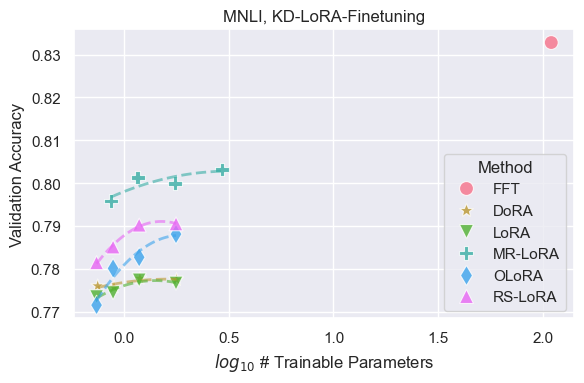

In [188]:
plotting_function(
    df,
    FILENAME = 'fig2-stu-acc.pdf',
    YLABEL = 'Validation Accuracy',
    YVAR = 'value',
)

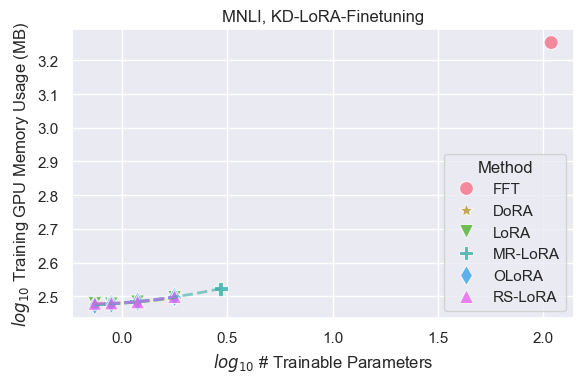

In [191]:
plotting_function(
    df,
    FILENAME = 'fig2-stu-gpumem.pdf',
    YLABEL = '$log_{10}$ Training GPU Memory Usage (MB)',
    YVAR = 'gpumem',
)

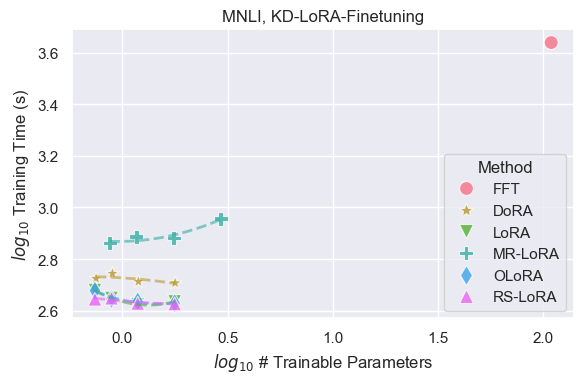

In [189]:
plotting_function(
    df,
    FILENAME = 'fig2-stu-traintime.pdf',
    YLABEL = '$log_{10}$ Training Time (s)',
    YVAR = 'traintime',
)

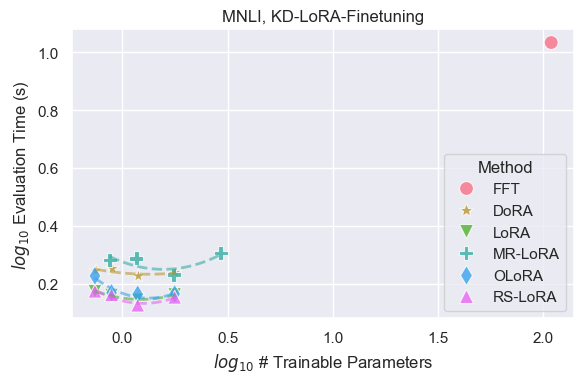

In [190]:
plotting_function(
    df,
    FILENAME = 'fig2-stu-evaltime.pdf',
    YLABEL = '$log_{10}$ Evaluation Time (s)',
    YVAR = 'evaltime',
)